# Ictonyx Example 1:  MNIST Variability Study

For a simple demonstration of the ictonyx API, let's examine the well known MNIST image data. Ictonyx makes it easy to repeat a basic TensorFlow model to assess training variability.

## Setup

We need ictonyx and TensorFlow. If you're in Colab, uncomment the pip install line.

In [ ]:
# !pip install ictonyx tensorflow

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input


import ictonyx as ix
from ictonyx import (
    ModelConfig, 
    KerasModelWrapper, 
    ArraysDataHandler,
    run_variability_study,
    plot_variability_summary
)

print(f"TensorFlow: {tf.__version__}")
print(f"Ictonyx: {ix.__version__}")

2026-02-11 22:45:02.327808: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 22:45:02.357917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-11 22:45:02.357944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-11 22:45:02.358828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-11 22:45:02.363857: I tensorflow/core/platform/cpu_feature_guar

TensorFlow: 2.15.0
Ictonyx: 0.0.5


## Load MNIST

The classic. 60,000 training images of handwritten digits, 10,000 test images. Each image is 28x28 grayscale.

In [2]:
# Load and preprocess MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1] and add channel dimension
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train[..., np.newaxis]  # Shape: (60000, 28, 28, 1)
X_test = X_test[..., np.newaxis]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


## Define the Model

For this example, let's consider a basic CNN. One conv layers, one dense layer, and softmax output. Nothing fancy — we're not trying to set records here; only to demonstrate and measure the variability in training a CNN.

In [3]:
def create_cnn(config: ModelConfig) -> KerasModelWrapper:
    """Build a simple CNN for MNIST classification."""
    
    model = Sequential([
        Input(shape=(28, 28, 1)),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return KerasModelWrapper(model)

# Quick sanity check
test_model = create_cnn(ModelConfig({}))
test_model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 347146 (1.32 MB)
Trainable params: 347146 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

2026-02-11 22:47:14.274902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-11 22:47:14.334498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-11 22:47:14.336933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Configure the Study

Completing a variability study with ictonyx requires:
1. A `ModelConfig` with training parameters
2. A `DataHandler` that knows how to serve our data

For this example, we'll use a ModelConfig with parameters for 12 epochs and a batch size of 64, and an ArraysDataHandler.

In [4]:
# Training configuration
config = ModelConfig({
    'epochs': 12,
    'batch_size': 64,
    'verbose': 0  # Suppress per-epoch output
})

# Data handler for numpy arrays
data_handler = ArraysDataHandler(X_train, y_train)

print(f"Training config: {config.epochs} epochs, batch size {config.batch_size}")
print(f"Data: {len(X_train)} samples")

Training config: 12 epochs, batch size 64
Data: 60000 samples


## Run the Variability Study

This is the core function for the ictonyx library. We're going to train the same model architecture 10 times on the same training data, each time with a fresh initialization. 

In [5]:
results = run_variability_study(
    model_builder=create_cnn,
    data_handler=data_handler,
    model_config=config,
    num_runs=10
)

print(results.summarize())

Loading and preparing data...
Array splits - Train: 42000, Val: 6000, Test: 12000
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 12
  Execution mode: in standard mode

 - Run 1: Training...


/home/appuser/projects/ictonyx/ictonyx/memory.py:192: UserWarning: TensorFlow setup failed: Physical devices cannot be modified after being initialized
  warnings.warn(f"TensorFlow setup failed: {e}")
/home/appuser/projects/ictonyx/ictonyx/runners.py:74: UserWarning: Memory setup incomplete. Consider using process isolation for better memory control: use_process_isolation=True
  warnings.warn(
2026-02-11 22:51:17.137412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2026-02-11 22:51:17.191808: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-02-11 22:51:17.300872: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-02-11 22:51:17.331308: I external/local_xla/xla/service/service.cc:168] XLA service 0x5badb344ffe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devic

375/375 [==============================] - 0s 817us/step - loss: 0.0724 - accuracy: 0.9821
 - Run 1: Completed successfully
 - Run 2: Training...
375/375 [==============================] - 0s 804us/step - loss: 0.0582 - accuracy: 0.9854
 - Run 2: Completed successfully
 - Run 3: Training...
375/375 [==============================] - 0s 693us/step - loss: 0.0636 - accuracy: 0.9849
 - Run 3: Completed successfully
 - Run 4: Training...
375/375 [==============================] - 0s 784us/step - loss: 0.0635 - accuracy: 0.9845
 - Run 4: Completed successfully
 - Run 5: Training...
375/375 [==============================] - 0s 755us/step - loss: 0.0655 - accuracy: 0.9823
 - Run 5: Completed successfully
 - Run 6: Training...
375/375 [==============================] - 0s 721us/step - loss: 0.0706 - accuracy: 0.9842
 - Run 6: Completed successfully
 - Run 7: Training...
375/375 [==============================] - 0s 715us/step - loss: 0.0716 - accuracy: 0.9829
 - Run 7: Completed successfully


## Visualizing the Results

Numbers are fine, but a picture makes the variability visceral. The plot shows training curves for all runs, plus the distribution of final accuracies.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


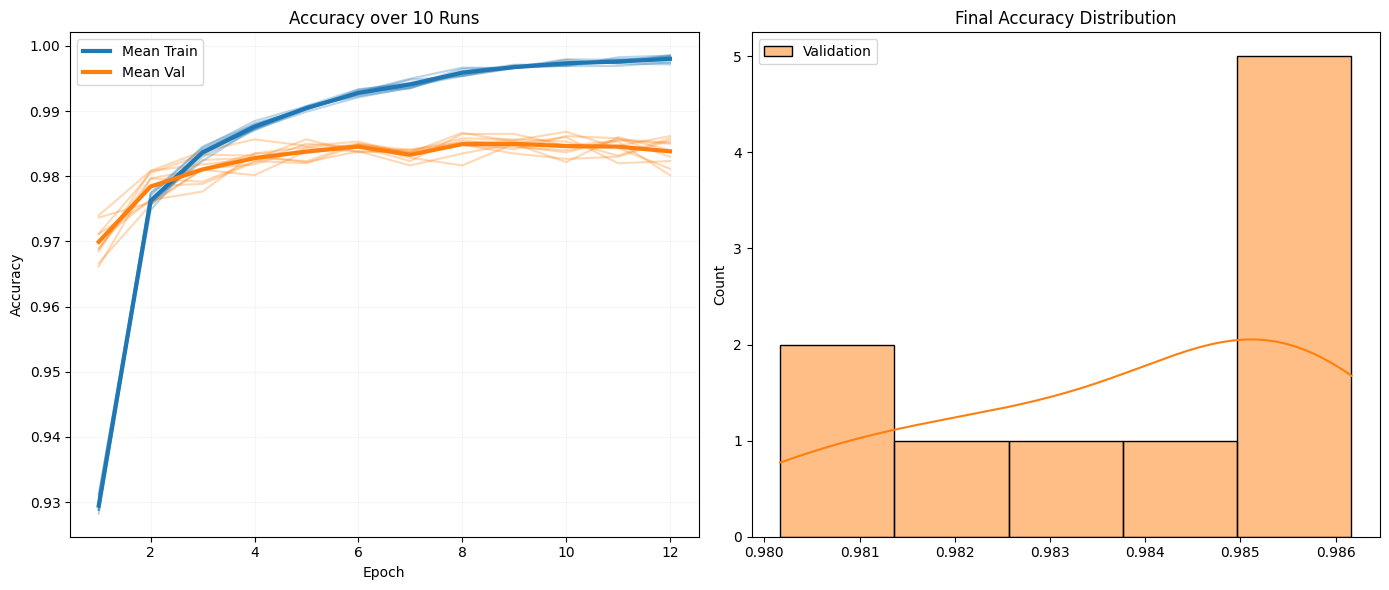

In [6]:
plot_variability_summary(
    all_runs_metrics_list=results.all_runs_metrics,
    final_metrics_series=results.final_metrics['val_accuracy'],
    metric='accuracy'
)